# TFGENZOO_Tutorial (1) What is the invertible layer
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/MokkeMeguru/blob/master/tutorials/01_What_is_the_invertible_layer.ipynb)

Invertible layer is the component of the Flow-based Model.

Flow-based Model is one of the generative neural networks like GANs and VAEs

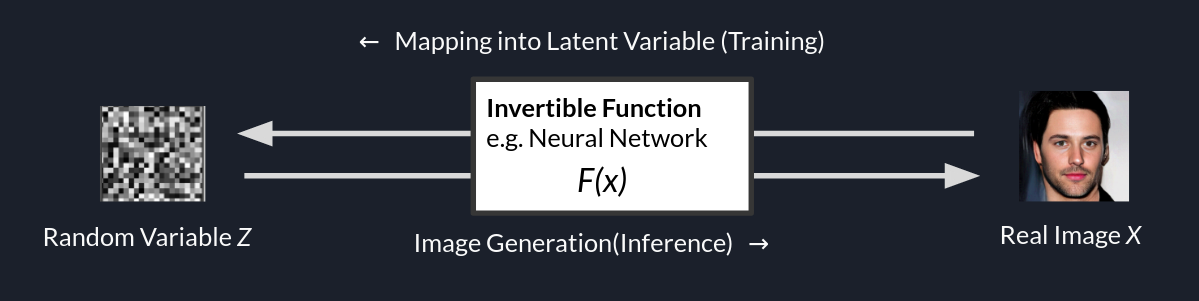

"**Invertible**", is the importest word in Flow-based Model.

We **should** use  bi-directional function as each layer.

These layers constructs the Flow-based Model like OpenAI's Glow, Google's RealNVP, NeuralODE, and i-RevNet / i-ResNet.

# What is the TFGENZOO
TFGENZOO is the library  to help constructing generative neural networks. 

Now (v1.2.x) ,  we supported to construct basic Flow-based Model like Glow.

In [ ]:
# Install TFGENZOO
!pip install TFGENZOO==1.2.4.post6

     |████████████████████████████████| 51kB 1.6MB/s 


In [ ]:
import tensorflow as tf
import TFGENZOO
print(f'Tensorflow {tf.__version__} / TFGENZO {TFGENZOO.__version__}')

Tensorflow 2.2.0 / TFGENZO 1.2.4.post6


# Three components of Flow-based Model
The main components of Flow-based Model is 

1. Normalizing
2. Permuting
3. Coupling

Normalizing is the layer to normalize **input tensor**.

Permuting is the layer that shuffle element of input tensor.

Coupling is the layer is convert the input tensor into the tensor following the distribution e.g. gaussian.

We implemented some basic Layer with detailed document. 
If you want to know the formula or implementation detail, please visit our Documentation from the repo. https://github.com/MokkeMeguru/TFGENZOO .

And also, you can confirm the  document from  your coding environment such as VSCode or Emacs or Vim with Python Language Server Protocol.

## Normalization : Actnorm
Actnorm is the layer  proposed in Glow (OpenAI) 

In [ ]:
from TFGENZOO.flows import Actnorm

actnorm = Actnorm()

# input data is the 3-D data like the rgb image.
x = tf.random.normal([16, 32, 32, 3])

# here is the forward function
z, log_det_jacobian = actnorm(x)

# here is the inverse function

rev_x, inverse_log_det_jacobian = actnorm(z, inverse=True)

initialization at actnorm_20


You can see the message "initialization at actrnom".

It is the important log about Actnorm.
Actrnom requires **data-dependent initialization** which initialize the first batch of dataset.

In [ ]:
print(f'reconstruction loss is {tf.reduce_mean((rev_x - x)**2)}, and also, reconstruction effect is  {tf.reduce_mean(log_det_jacobian + inverse_log_det_jacobian)}')

reconstruction loss is 2.8776044911580636e-15, and also, reconstruction effect is  0.0


## Permutation: Inv1x1Conv
Invertible 1x1Conv is  proposed in Glow (OpenAI)

In [ ]:
from TFGENZOO.flows import Inv1x1Conv

inv1x1Conv = Inv1x1Conv()

# input data is the 3-D data like the rgb image.
x = tf.random.normal([16, 32, 32, 3])

# here is the forward function
z, log_det_jacobian = inv1x1Conv(x)

# here is the inverse function

rev_x, inverse_log_det_jacobian = inv1x1Conv(z, inverse=True)

print(f'reconstruction loss is {tf.reduce_mean((rev_x - x)**2)}, and also, reconstruction effect is  {tf.reduce_mean(log_det_jacobian + inverse_log_det_jacobian)}')

reconstruction loss is 9.438383946202156e-15, and also, reconstruction effect is  0.0


## Coupling: AffineCoupling
AffineCoupling is proposed in RealNVP

In [ ]:
from TFGENZOO.flows import AffineCoupling
import tensorflow.keras.layers as layers

channel = 6
assert channel % 2 == 0

scale_shift_net = tf.keras.Sequential([
                                       layers.Conv2D(32, 3, padding="same"),
                                       layers.Conv2D(64, 3, padding="same"),
                                       layers.Conv2D(64, 3, padding="same"),
                                       layers.Conv2D(channel, 3, padding="same")])

affineCoupling = AffineCoupling(scale_shift_net=scale_shift_net)

# input data is the 3-D data like the rgb image.
x = tf.random.normal([16, 16, 16, channel])

# here is the forward function
z, log_det_jacobian = affineCoupling(x)

# here is the inverse function

rev_x, inverse_log_det_jacobian = affineCoupling(z, inverse=True)

print(f'reconstruction loss is {tf.reduce_mean((rev_x - x)**2)}, and also, reconstruction effect is  {tf.reduce_mean(log_det_jacobian + inverse_log_det_jacobian)}')

reconstruction loss is 8.330419217293498e-16, and also, reconstruction effect is  0.0


# A Step of Flow: Norm. + Perm. + Coupling
We generally use the set of flow layers, Norm.+ Perm. + Coupling as **A Step of Flow**

We can construct the set as **FlowModule**


In [ ]:
from TFGENZOO.flows import FlowModule
from TFGENZOO.layers.resnet import ShallowResNet

channel = 6
assert channel % 2 == 0

fm = []
fm.append(Actnorm())
fm.append(Inv1x1Conv())
fm.append(AffineCoupling(scale_shift_net_template=lambda x: ShallowResNet(x)))

stepOfFlow = FlowModule(fm)


x = tf.random.normal([16, 16, 16, channel])

# here is the forward function
z, ldj = stepOfFlow(x)

# here is the inverse function
rev_x, ildj = stepOfFlow(z, inverse=True)

print(f'reconstruction loss is {tf.reduce_mean((rev_x - x)**2)}, and also, reconstruction effect is  {tf.reduce_mean(log_det_jacobian + inverse_log_det_jacobian)}')

initialization at actnorm_32
initialization at actnorm_activation_46
initialization at actnorm_activation_47
reconstruction loss is 1.3926969081830883e-14, and also, reconstruction effect is  0.0


This procedure is the same as the below code. (To simplify, the below example removes the calculation about log_det_jacobian)

In [ ]:
actnorm = Actnorm()
inv1x1Conv = Inv1x1Conv()
affineCoupling = AffineCoupling(scale_shift_net_template=lambda x: ShallowResNet(x))

tx = x
tx, _ = actnorm(tx)
tx, _ = inv1x1Conv(tx)
tx, _ = affineCoupling(tx)

tz = tx
tz,_ = affineCoupling(tz, inverse=True)
tz,_ = inv1x1Conv(tz, inverse=True)
tz,_  = actnorm(tz, inverse=True)

rev_x = tz

print(f'reconstruction loss is {tf.reduce_mean((rev_x - x)**2)}')

initialization at actnorm_31
initialization at actnorm_activation_44
initialization at actnorm_activation_45
reconstruction loss is 1.2398427824775876e-14


# Conclusion

- Flow-based Model is the invertible neural network. Besides, this model is constructed by some invertible layers.
- The main layers of invertible layers are **Normalization**,  **Permutation** and **Coupling**
- The set of the three layer is often called **A step of Flow**.